In [1]:
import warnings

warnings.filterwarnings('ignore')

from collections import OrderedDict
from time import time
from scipy.stats import spearmanr
from logbook import Logger, StderrHandler, INFO
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, EWMA, Returns
from zipline.pipeline.factors.technical import RSI, MACDSignal, TrueRange
from zipline import run_algorithm
# although zipline.api have date_rules and time_rules, the error red underline has been shown. IDK abt this
# maybe library version dependencies conflict? However, this program works well.
from zipline.api import (attach_pipeline, pipeline_output, date_rules, time_rules, schedule_function,
                         set_slippage, set_commission, record, order_target, order_target_percent)
from zipline.finance import commission, slippage
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
# Setup Logging
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                                          '{record.level_name}: {record.func_name}: {record.message}', level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

# Target long/short positions
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15

UNIVERSE = 250

# Length of the training period (memory-intensive due to pre-processing)
TRAINING_PERIOD = 252 * 2

# train to predict 1 day forward returns
N_FORWARD_DAYS = 1

# How often to trade; align with prediction horizon - N_FORWARD_DAYS & TREADE_FREQ
# for weekly, set to date_rules.week_start(days_offset=1)
TRADE_FREQ = date_rules.every_day()

# data has been created until 2018. Thus, this has been tested until the end of 2017
start = pd.Timestamp('2015-01-01', tz='UTC').replace(tzinfo=None)
end = pd.Timestamp('2017-12-31', tz='UTC').replace(tzinfo=None)

In [3]:
# Factor Engineering 1 - Momentum1
def Price_Momentum_3M():
    return Returns(window_length=63)


# Factor Engineering 1 - Momentum2
def Returns_39W():
    return Returns(window_length=215)


# Factor Engineering 2 - Volatility
# CustomFactor - User-defined function should be inherited the CustomFactor
class Vol_3M(CustomFactor):
    inputs = [Returns(window_length=2)]
    window_length = 63 # 3 months

    def compute(self, today, assets, out, rets):
        out[:] = np.nanstd(rets, axis=0)


# Factor Engineering 3 - Mean Reversion
class Mean_Reversion_1M(CustomFactor):
    # standardized difference between latest monthly return
    # and their annual average
    inputs = [Returns(window_length=21)]
    window_length = 252

    def compute(self, today, assets, out, monthly_rets):
        out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / np.nanstd(monthly_rets, axis=0)


# Factor Engineering 4 - Money Flow Volume
class Moneyflow_Volume_5d(CustomFactor):
    inputs = [USEquityPricing.close, USEquityPricing.volume]
    window_length = 5

    def compute(self, today, assets, out, close, volume):
        mfvs = []

        for col_c, col_v in zip(close.T, volume.T):
            # denominator
            denominator = np.dot(col_c, col_v)
            # numerator
            numerator = 0.
            for n, price in enumerate(col_c.tolist()):
                if price > col_c[n - 1]:
                    numerator += price * col_v[n]
                else:
                    numerator -= price * col_v[n]

            mfvs.append(numerator / denominator)
        out[:] = mfvs


# Factor Engineering 5 - Price Trend
class Trendline(CustomFactor): # trend regression for 1y
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        X = np.arange(self.window_length).reshape(-1, 1).astype(float)
        X -= X.mean()
        Y = close - np.nanmean(close, axis=0)  # np.nanmean: mean value that Nan ignored
        out[:] = (X.T @ Y / np.var(X)) / self.window_length

# Factor Engineering 6 - Oscillator
class Price_Oscillator(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        four_week_period = close[-20:]
        out[:] = (np.nanmean(four_week_period, axis=0) / np.nanmean(close, axis=0)) - 1.

# Combine Features
vol_3M = Vol_3M()
mean_reversion_1M = Mean_Reversion_1M()
macd_signal_10d = MACDSignal()
moneyflow_volume_5d = Moneyflow_Volume_5d()
trendline = Trendline()
price_oscillator = Price_Oscillator()
price_momentum_3M = Price_Momentum_3M()
returns_39W = Returns_39W()
true_range = TrueRange()

features = {
    'Vol 3M': vol_3M,
    'Mean Reversion 1M': mean_reversion_1M,
    'MACD Signal 10d': macd_signal_10d,
    'Moneyflow Volume 5D': moneyflow_volume_5d,
    'Trendline': trendline,
    'Price Oscillator': price_oscillator,
    'Price Momentum 3M': price_momentum_3M,
    '39 Week Returns': returns_39W,
    'True Range': true_range
}

In [4]:
class LinearModel(CustomFactor):
    train_on_weekday = [0, 2, 4] # 3 times training per week

    def __init__(self, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        self._scaler = StandardScaler()
        self._model = SGDRegressor(penalty='L2')
        self._trained = False

    # chk whether executing training or not
    def _maybe_train_model(self, today, returns, inputs):
        if (today.weekday() in self.train_on_weekday) or not self._trained:
            self._train_model(today, returns, inputs)

    def _train_model(self, today, returns, inputs):
        scaler = self._scaler
        model = self._model

        shift_by = N_FORWARD_DAYS + 1
        outcome = returns[shift_by:].flatten()
        features = np.dstack(inputs)[:-shift_by]
        n_days, n_stocks, n_features = features.shape
        features = features.reshape(-1, n_features)
        features = features[~np.isnan(outcome)]
        outcome = outcome[~np.isnan(outcome)]
        outcome = outcome[np.all(~np.isnan(features), axis=1)]
        features = features[np.all(~np.isnan(features), axis=1)]
        features = scaler.fit_transform(features)

        start = time()
        model.fit(X=features, y=outcome)
        log.info('{} | {:.2f}s'.format(today.date(), time() - start))
        self._trained = True

    def compute(self, today, assets, out, returns, *inputs):
        self._maybe_train_model(today, returns, inputs)

        # Predict most recent feature values
        X = np.dstack(inputs)[-1]
        missing = np.any(np.isnan(X), axis=1)
        X[missing, :] = 0
        X = self._scaler.transform(X)
        preds = self._model.predict(X)
        out[:] = np.where(missing, np.nan, preds)

In [5]:
# ML Pipeline
def make_ml_pipeline(universe, window_length=21, n_forward_days=5):
    pipeline_columns = OrderedDict()

    # ensure that returns is the first input
    pipeline_columns['Returns'] = Returns(inputs=[USEquityPricing.open], mask=universe,
                                          window_length=n_forward_days + 1)

    # convert factors to ranks; append to pipeline
    pipeline_columns.update({k: v.rank(mask=universe) for k, v in features.items()})

    # Create ML pipeline factor.
    # window_length : training period
    pipeline_columns['predictions'] = LinearModel(inputs=pipeline_columns.values(),
                                                  window_length=window_length + n_forward_days,
                                                  mask=universe)

    return Pipeline(screen=universe, columns=pipeline_columns)

In [6]:
# Universe
def make_universe():
    # Set screen
    dollar_volume = AverageDollarVolume(window_length=90)
    return dollar_volume.top(UNIVERSE)

universe = make_universe()

In [7]:
# Initialize Algorithm
def initialize(context):
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0, min_trade_cost=0))

    schedule_function(rebalance, TRADE_FREQ, date_rules.every_day(), time_rules.market_open(hours=1, minutes=30), )

    schedule_function(record_vars, date_rules.every_day(), time_rules.market_close())

    ml_pipeline = make_ml_pipeline(universe, n_forward_days=N_FORWARD_DAYS, window_length=TRAINING_PERIOD)

    # Create our dynamic stock selector.
    attach_pipeline(ml_pipeline, 'ml_model')

    context.past_predictions = {}
    context.ic = 0
    context.rmse = 0
    context.mae = 0
    context.returns_spread_bps = 0

In [8]:
# Evaluate Predictive Accuracy
def evaluate_predictions(output, context):
    # past predictions to evaluate MDL performance
    # A day has passed, shift days and drop old ones as series data
    context.past_predictions = {k - 1: v for k, v in context.past_predictions.items() if k > 0}

    if 0 in context.past_predictions:
        # Use today's n-day returns as future returns to evaluate predictions
        returns, predictions = (output['Returns'].dropna()
                                .align(context.past_predictions[0].dropna(), join='inner'))
        if len(returns) > 0 and len(predictions) > 0:
            context.ic = spearmanr(returns, predictions)[0]
            context.rmse = np.sqrt(mean_squared_error(returns, predictions))
            context.mae = mean_absolute_error(returns, predictions)

            long_rets = returns[predictions > 0].mean()
            short_rets = returns[predictions < 0].mean()
            context.returns_spread_bps = (long_rets - short_rets) * 10000

    # Store current predictions
    context.past_predictions[N_FORWARD_DAYS] = context.predicted_returns

In [9]:
# called every day b4 MKT Open
def before_trading_start(context, data):
    output = pipeline_output('ml_model')
    context.predicted_returns = output['predictions']
    context.predicted_returns.index.set_names(['equity'], inplace=True)

    evaluate_predictions(output, context)

    # These are the securities that we are interested in trading each day.
    context.security_list = context.predicted_returns.index

In [10]:
# execute orders and change positions by schedule_function() timing
def rebalance(context, data):
    predictions = context.predicted_returns

    # Drop stocks that can not be traded
    predictions = predictions.loc[data.can_trade(predictions.index)]
    longs = (predictions[predictions > 0].sort_values(ascending=False)[:N_LONGS].index.tolist())
    shorts = (predictions[predictions < 0].sort_values()[:N_SHORTS].index.tolist())
    targets = set(longs + shorts)
    for position in context.portfolio.positions:
        if position not in targets:
            order_target(position, 0)

    n_longs, n_shorts = len(longs), len(shorts)
    if n_longs > MIN_POSITIONS and n_shorts > MIN_POSITIONS:
        for stock in longs:
            order_target_percent(stock, target=1 / n_longs)
        for stock in shorts:
            order_target_percent(stock, target=-1 / n_shorts)
    else:
        for stock in targets:
            if stock in context.portfolio.positions:
                order_target(stock, 0)

In [11]:
def record_vars(context, data):
    record(leverage=context.account.leverage, ic=context.ic, rmse=context.rmse, mae=context.mae,
           returns_spread_bps=context.returns_spread_bps)

In [12]:
go = time()
results = run_algorithm(start=start, end=end, initialize=initialize, before_trading_start=before_trading_start,
                        capital_base=1e6, data_frequency='daily', benchmark_returns=None, bundle='quandl')

print('{:.2f}'.format(time() - go))

[2023-04-13 02:19:37.584535]: INFO: _train_model: 2015-01-02 | 0.07s
[2023-04-13 02:19:37.723167]: INFO: _train_model: 2015-01-05 | 0.08s
[2023-04-13 02:19:37.890736]: INFO: _train_model: 2015-01-07 | 0.09s
[2023-04-13 02:19:38.016379]: INFO: _train_model: 2015-01-09 | 0.06s
[2023-04-13 02:20:12.307983]: INFO: _train_model: 2015-01-12 | 0.06s
[2023-04-13 02:20:12.468550]: INFO: _train_model: 2015-01-14 | 0.09s
[2023-04-13 02:20:12.592223]: INFO: _train_model: 2015-01-16 | 0.06s
[2023-04-13 02:20:12.714895]: INFO: _train_model: 2015-01-21 | 0.06s
[2023-04-13 02:20:12.846541]: INFO: _train_model: 2015-01-23 | 0.07s
[2023-04-13 02:20:12.997102]: INFO: _train_model: 2015-01-26 | 0.10s
[2023-04-13 02:20:13.151687]: INFO: _train_model: 2015-01-28 | 0.09s
[2023-04-13 02:20:13.284332]: INFO: _train_model: 2015-01-30 | 0.07s
[2023-04-13 02:20:13.404012]: INFO: _train_model: 2015-02-02 | 0.07s
[2023-04-13 02:20:13.525688]: INFO: _train_model: 2015-02-04 | 0.07s
[2023-04-13 02:20:13.687286]: INFO

535.70


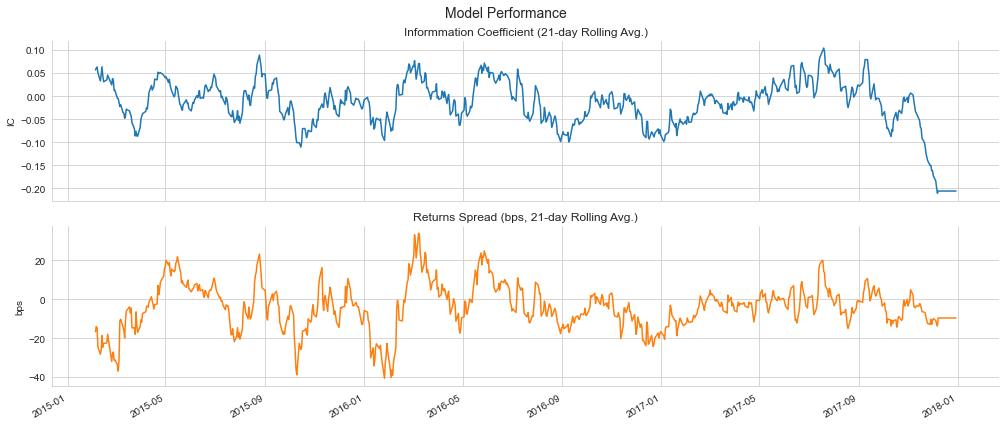

In [13]:
axes = (results[['ic', 'returns_spread_bps']].dropna().rolling(21).mean()
        .plot(subplots=True, layout=(2, 1), figsize=(14, 6),
              title=['Informmation Coefficient (21-day Rolling Avg.)',
                     'Returns Spread (bps, 21-day Rolling Avg.)'],
              legend=False))
axes = axes.flatten()
axes[0].set_ylabel('IC')
axes[1].set_ylabel('bps')
plt.suptitle('Model Performance', fontsize=14)
plt.subplots_adjust(top=.9);

Text(0.5, 1.0, 'Cumulative Returns - In and Out-of-Sample')

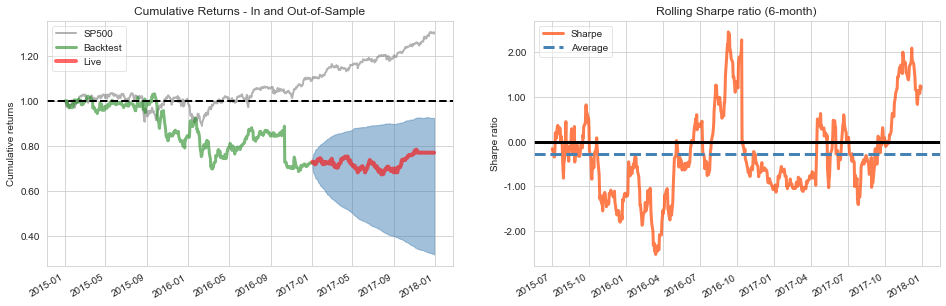

In [14]:
# Get PyFolio Input
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# Get BM Data
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

# Custom Performance Plots
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns, factor_returns=benchmark, live_start_date='2017-01-01', logy=False,
                     cone_std=2, legend_loc='best', volatility_match=False,
                     cone_function=forecast_cone_bootstrap, ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1])
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.69,2015-09-24,2017-07-28,NaT,NaN
1,7.57,2015-03-11,2015-04-07,2015-09-18,138
2,3.14,2015-01-06,2015-01-14,2015-01-29,18
3,2.53,2015-02-11,2015-02-23,2015-03-09,19
4,1.45,2015-02-02,2015-02-03,2015-02-11,8


Stress Events,mean,min,max
Fall2015,0.03%,-6.01%,2.46%
New Normal,-0.03%,-18.04%,5.04%


Top 10 long positions of all time,max
sid,
DTV,771.38%
OMC,8.16%
BLK,7.80%
FCX,5.48%
CSX,5.03%
VRX,5.02%
CHK,4.99%
SWN,4.98%
SE,4.92%


Top 10 short positions of all time,max
sid,
BIDU,-6.46%
WYNN,-6.43%
SLB,-6.42%
APC,-6.40%
PH,-6.36%
MON,-6.34%
RIG,-6.34%
SBUX,-6.34%
F,-6.33%


Top 10 positions of all time,max
sid,
DTV,771.38%
OMC,8.16%
BLK,7.80%
BIDU,6.46%
WYNN,6.43%
SLB,6.42%
APC,6.40%
PH,6.36%
MON,6.34%


SpecificationError: nested renamer is not supported

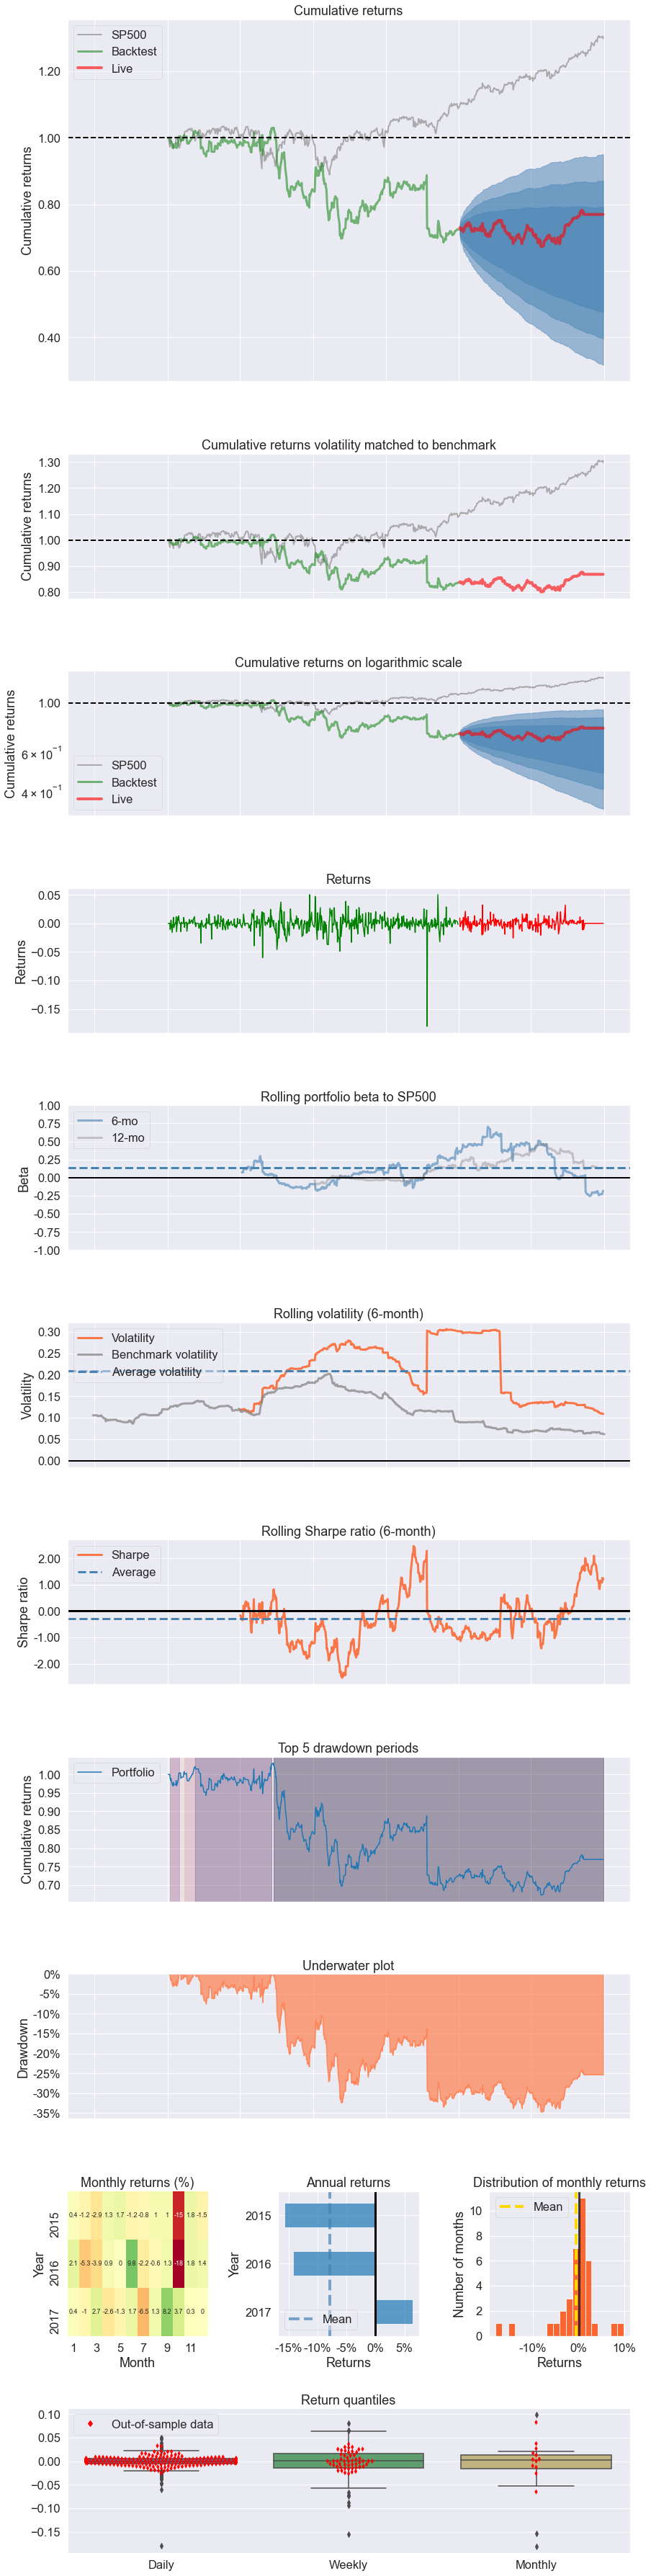

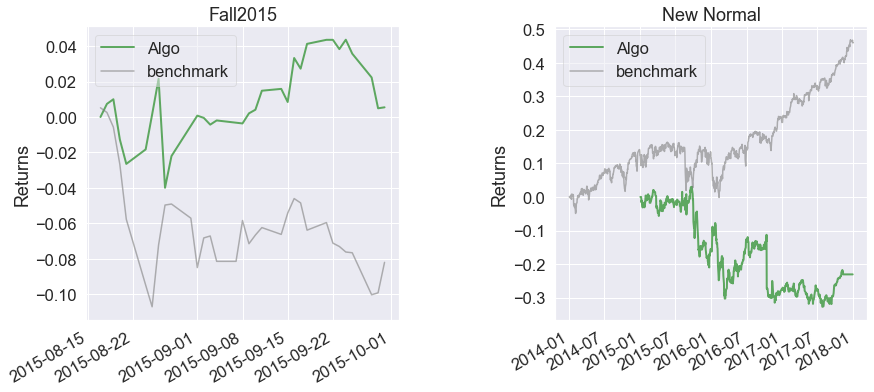

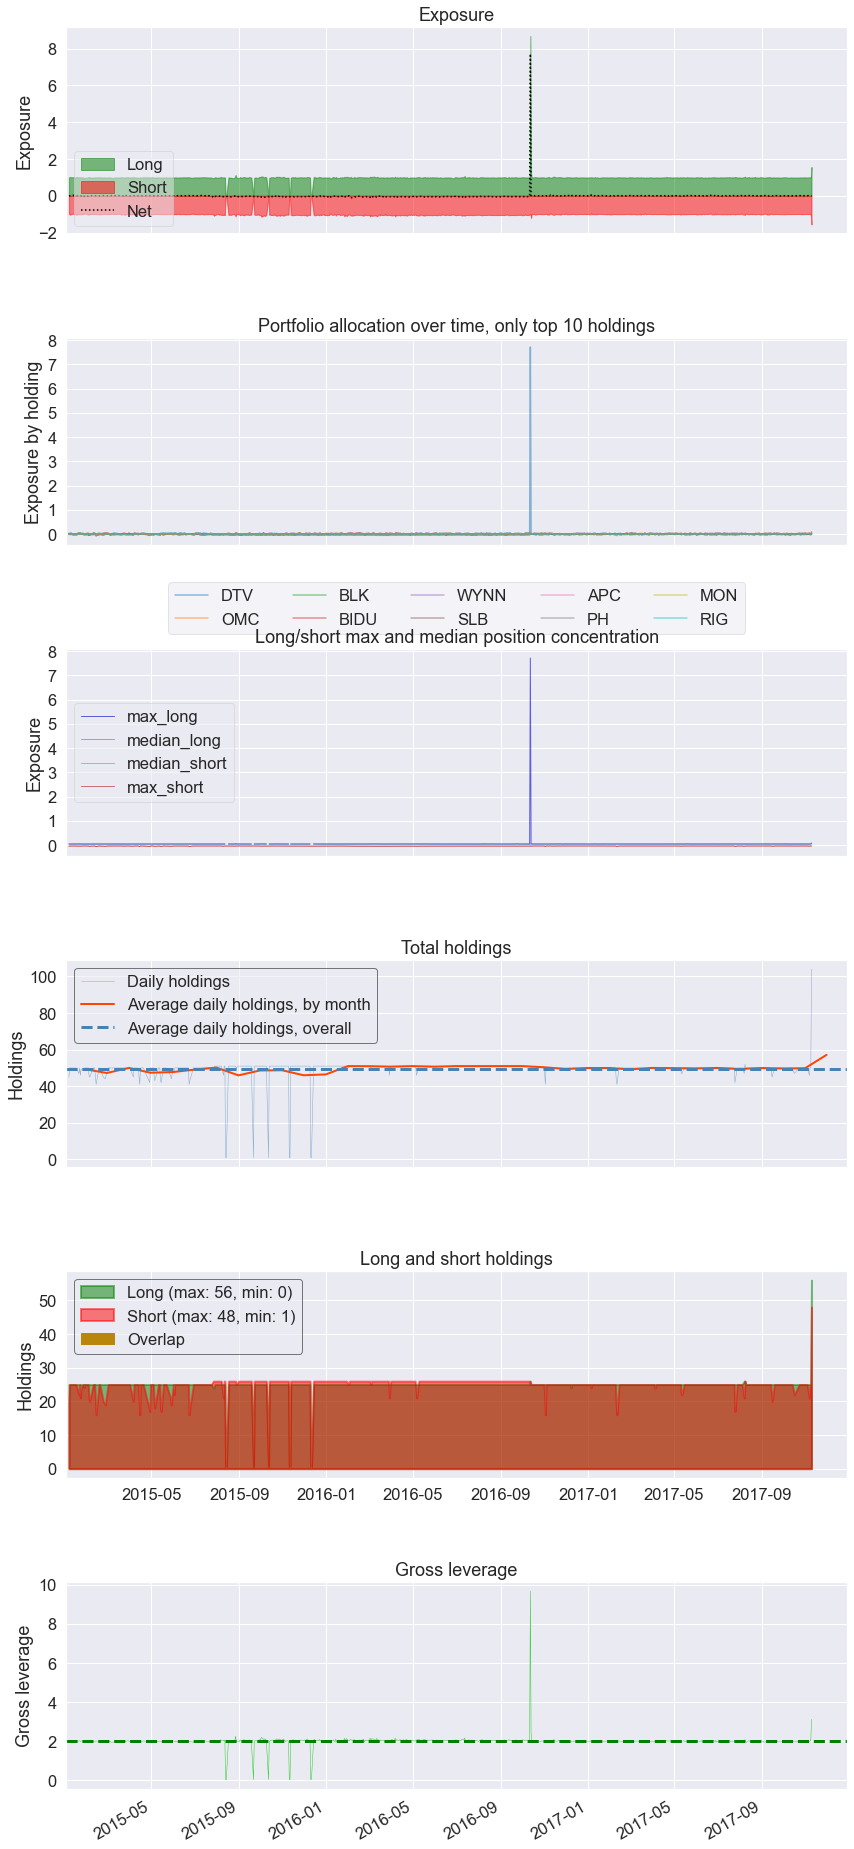

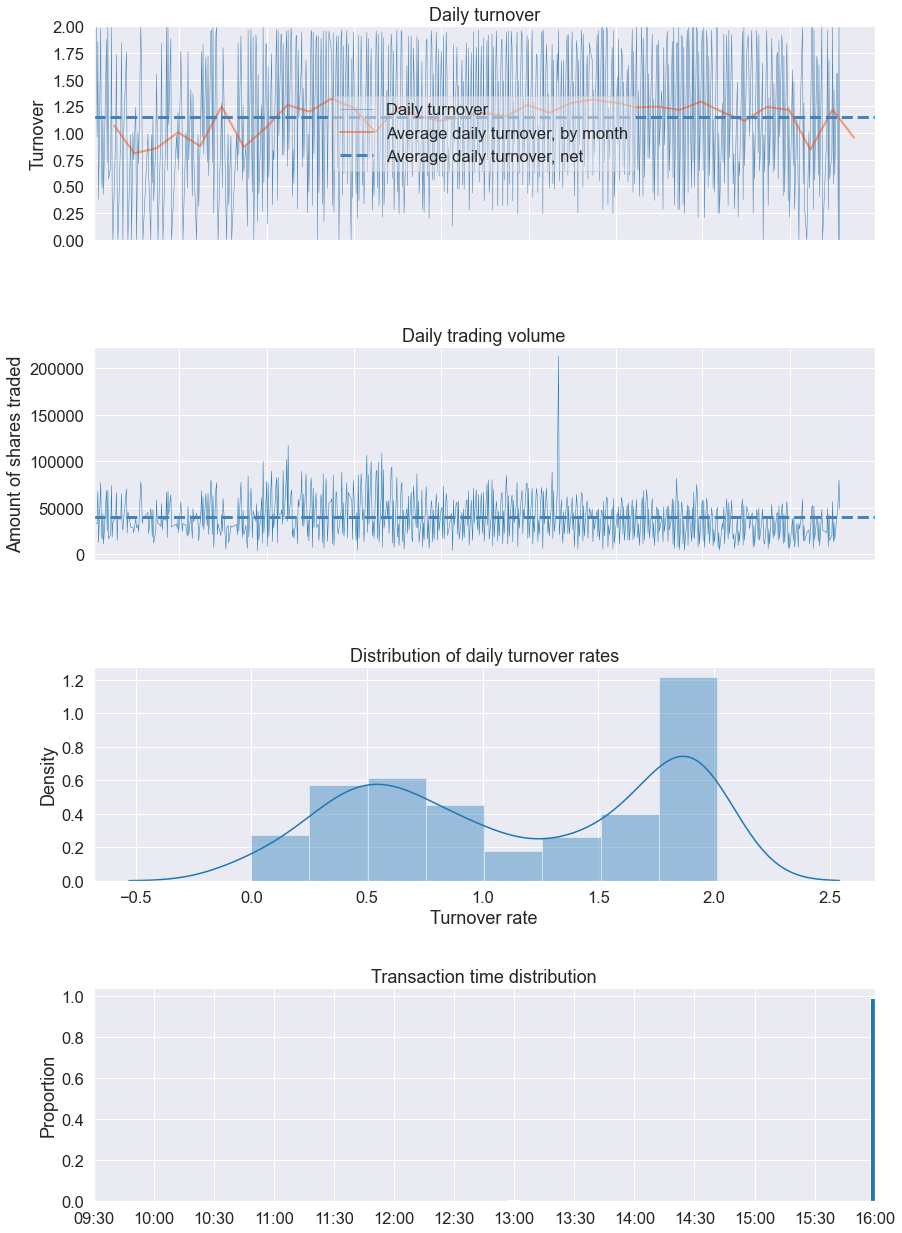

In [15]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=benchmark,
                          live_start_date='2017-01-01', round_trips=True)

In [1]:
import empyrical, pyfolio

empyrical.__version__
pyfolio.__version__

'0.9.2+75.g4b901f6'